# LAB 11 - Consultoria Customer churn
Diego Duarte

Paula Barillas

In [70]:
!pip -q install pyspark

In [71]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Lab Spark — Customer Churn").getOrCreate()
print("Spark version:", spark.version)

Spark version: 3.5.1


## Obtención de Data

In [72]:
data_path = '/abandono_clientes.csv'
new_path = '/clientes_nuevos.csv'

In [73]:
df = spark.read.option('header', True).option('inferSchema', True).csv(data_path)
df_new = spark.read.option('header', True).option('inferSchema', True).csv(new_path)

## Analisis Exploratorio

In [74]:
print('Registros históricos:', df.count())
print('Registros nuevos:', df_new.count())

Registros históricos: 900
Registros nuevos: 6


In [75]:
df.printSchema()
df.show(5, truncate=False)

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------------------------------------+---------------------------+-----+
|Names           |Age |Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date       |Location                                          |Company                    |Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------------------------------------+---------------------------+-----+
|Cameron Williams|42.0|11066.8       |0              |7.22

In [76]:
num_companies = df.select('Company').distinct().count()
print(f"Número de compañías únicas: {num_companies}")

Número de compañías únicas: 873


## Limpieza

In [77]:
from pyspark.sql.functions import col, to_date, current_date, datediff

# Convertir fecha de abordaje a tipo fecha
df = df.withColumn('Onboard_date_dt', to_date(col('Onboard_date')))
df_new = df_new.withColumn('Onboard_date_dt', to_date(col('Onboard_date')))

# Crear nueva variable: días desde que fue abordado
df = df.withColumn('days_since_onboard', datediff(current_date(), col('Onboard_date_dt')))
df_new = df_new.withColumn('days_since_onboard', datediff(current_date(), col('Onboard_date_dt')))

# Eliminar columnas que no ayudan al modelo
cols_to_drop = ['Names', 'Company', 'Onboard_date', 'Onboard_date_dt']

for c in cols_to_drop:
    if c in df.columns:
        df = df.drop(c)

print("Columnas después de limpieza:")
print(df.columns)


df.groupBy('Churn').count().show()

Columnas después de limpieza:
['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Location', 'Churn', 'days_since_onboard']
+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



## Pipeline

In [78]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Imputer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col

# 1️Definir columnas numéricas y categóricas
num_cols = [c for c, t in df.dtypes if t in ('int', 'double') and c != 'Churn']
cat_cols = [c for c, t in df.dtypes if t not in ('int', 'double') and c != 'Churn']

print('Num cols:', num_cols)
print('Cat cols:', cat_cols)

# Imputar valores numéricos si hay nulos
imputer = Imputer(inputCols=num_cols, outputCols=[c + '_imputed' for c in num_cols])
num_imputed_cols = [c + '_imputed' for c in num_cols]

# Indexar y codificar categóricas
indexers = [StringIndexer(inputCol=c, outputCol=c + '_idx', handleInvalid='keep') for c in cat_cols]
encoders = [OneHotEncoder(inputCol=c + '_idx', outputCol=c + '_ohe') for c in cat_cols]

# VectorAssembler y escalado
assembler_inputs = num_imputed_cols + [c + '_ohe' for c in cat_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='raw_features')
scaler = StandardScaler(inputCol='raw_features', outputCol='features')

# Crear columna de peso para clase minoritaria (Churn=1)
churn_count = df.filter(col('Churn') == 1).count()
not_churn_count = df.filter(col('Churn') == 0).count()
ratio = not_churn_count / churn_count
print(f"Peso para la clase Churn=1: {ratio:.2f}")

df = df.withColumn('weight', when(col('Churn') == 1, ratio).otherwise(1.0))

# Definir Logistic Regression con weightCol
lr = LogisticRegression(
    labelCol='Churn',
    featuresCol='features',
    probabilityCol='probability',
    predictionCol='prediction',
    weightCol='weight'
)

#  Crear pipeline
stages = []
stages.append(imputer)
stages += indexers
stages += encoders
stages.append(assembler)
stages.append(scaler)
stages.append(lr)

pipeline = Pipeline(stages=stages)

# División train/test
train, test = df.randomSplit([0.8, 0.2], seed=42)
print('Train:', train.count(), 'Test:', test.count())




Num cols: ['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'days_since_onboard']
Cat cols: ['Location']
Peso para la clase Churn=1: 5.00
Train: 754 Test: 146


## Training

In [79]:
# Entrenar modelo
model = pipeline.fit(train)

# Predicción en test
preds = model.transform(test)

# Evaluación
evaluator_auc = BinaryClassificationEvaluator(labelCol='Churn', rawPredictionCol='probability', metricName='areaUnderROC')
auc = evaluator_auc.evaluate(preds)
print(f"AUC en test: {auc:.4f}")

evaluator_acc = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol='prediction', metricName='accuracy')
acc = evaluator_acc.evaluate(preds)
print(f"Accuracy en test: {acc:.4f}")

# Matriz de confusión
preds.groupBy('Churn', 'prediction').count().orderBy('Churn', 'prediction').show()

AUC en test: 0.9371
Accuracy en test: 0.8767
+-----+----------+-----+
|Churn|prediction|count|
+-----+----------+-----+
|    0|       0.0|  103|
|    0|       1.0|   13|
|    1|       0.0|    5|
|    1|       1.0|   25|
+-----+----------+-----+



## Nuevos Clientes

In [80]:
df_new.show(7, truncate=False)

+--------------+----+--------------+---------------+-----+---------+-------------------+---------------------------------------------------------+----------------+---------------+------------------+
|Names         |Age |Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date       |Location                                                 |Company         |Onboard_date_dt|days_since_onboard|
+--------------+----+--------------+---------------+-----+---------+-------------------+---------------------------------------------------------+----------------+---------------+------------------+
|Andrew Mccall |37.0|9935.53       |1              |7.71 |8.0      |2011-08-29 18:37:54|38612 Johnny Stravenue Nataliebury, WI 15717-8316        |King Ltd        |2011-08-29     |5170              |
|Michele Wright|23.0|7526.94       |1              |9.28 |15.0     |2013-07-22 18:19:54|21083 Nicole Junction Suite 332, Youngport, ME 23686-4381|Cannon-Benson   |2013-07-22     |4477              |
|Jere

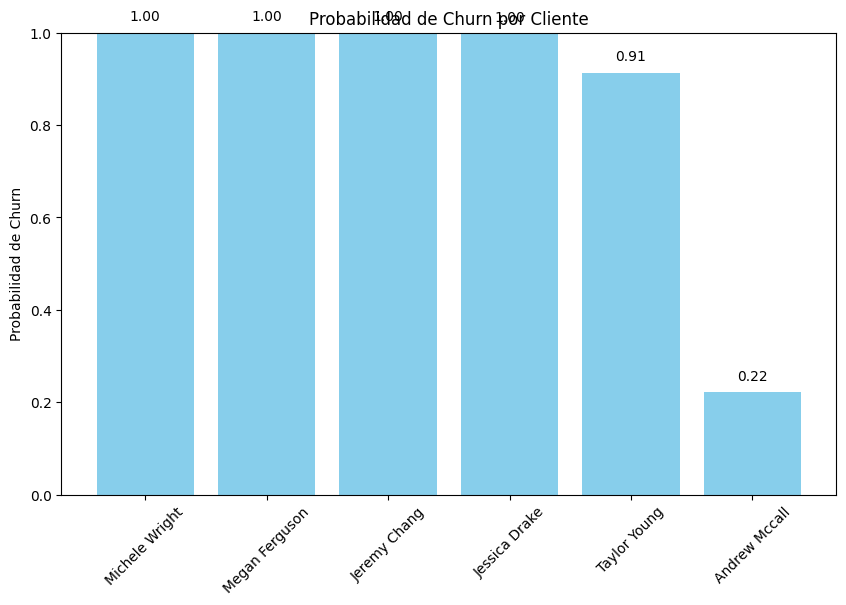

            Names  churn_probability
1  Michele Wright           1.000000
3  Megan Ferguson           1.000000
2    Jeremy Chang           0.999996
5   Jessica Drake           0.998396
4    Taylor Young           0.912932
0   Andrew Mccall           0.221259


In [81]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

# Aplicar pipeline al df_new
preds_new = model.transform(df_new)

# Extraer probabilidad de churn (probabilidad de 1)
get_prob_1 = udf(lambda v: float(v[1]) if v is not None else None, DoubleType())
preds_new = preds_new.withColumn('churn_probability', get_prob_1(col('probability')))

# Convertir a Pandas solo con Names y churn_probability
preds_pd = preds_new.select('Names', 'churn_probability').toPandas()
preds_pd = preds_pd.sort_values('churn_probability', ascending=False)

# Graficar
plt.figure(figsize=(10,6))
plt.bar(preds_pd['Names'], preds_pd['churn_probability'], color='skyblue')
plt.title('Probabilidad de Churn por Cliente')
plt.ylabel('Probabilidad de Churn')
plt.ylim(0,1)

# Etiquetas encima de las barras
for i, prob in enumerate(preds_pd['churn_probability']):
    plt.text(i, prob + 0.02, f'{prob:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

# Mostrar tabla
print(preds_pd)
